<a href="https://colab.research.google.com/github/Jenesha20/GenAI_Self_Learn/blob/main/langgraph_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q langgraph langchain langchain-community chromadb pypdf sentence-transformers transformers accelerate torch langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.6/329.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.1 MB/s eta 0:00:0

In [33]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional, List
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import pipeline
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import HuggingFacePipeline
from langchain_core.output_parsers import StrOutputParser

In [34]:
class MultiAgentState(TypedDict):
    question: str
    documents: Optional[str]
    chunks: Optional[List[str]]
    is_valid: bool
    answer: Optional[str]
    retry_count: int
    human_reviewed: bool

In [35]:
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

loader = PyPDFLoader(pdf_path)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = splitter.split_documents(docs)

embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(chunks, embedding)

Saving Jenesha_Malar.pdf to Jenesha_Malar (1).pdf


In [36]:
hf_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
llm = HuggingFacePipeline(pipeline=hf_pipeline)

Device set to use cpu


In [37]:
retriever = vectorstore.as_retriever()

# Define the prompt template for RAG
prompt_template = """Answer the user question ONLY using the following context. If the answer is not in the context, say \"Not in document\".
Context: {context}
Question: {question}"""
prompt = ChatPromptTemplate.from_template(prompt_template)

# Create the RAG chain
rag_chain = (prompt | llm | StrOutputParser())

def log_middleware(node_name, state):
    print(f"\n Middleware: Entering {node_name}")
    print("Current State Keys:", list(state.keys()))

In [38]:
def extract_agent(state: MultiAgentState):
    log_middleware("Extract Agent", state)

    retrieved = retriever.invoke(state["question"])

    extracted_chunks = [d.page_content for d in retrieved]

    return {
        "chunks": extracted_chunks,
        "documents": "\n\n".join(extracted_chunks),
        "retry_count": state["retry_count"] + 1
    }

In [39]:
def validate_agent(state: MultiAgentState):
    log_middleware("Validate Agent", state)

    docs = state.get("documents", "")

    is_good = docs is not None and len(docs.strip()) > 50

    print("Validation Result:", is_good)

    return {
        "is_valid": is_good
    }

In [40]:
def answer_agent(state: MultiAgentState):
    log_middleware("Answer Agent", state)

    # Use the globally defined rag_chain
    response = rag_chain.invoke({"context": state['documents'], "question": state['question']})

    return {
        "answer": response
    }

In [41]:
def human_review_agent(state: MultiAgentState):
    log_middleware("Human Review Agent", state)

    print("Extracted Context Preview:\n")
    print(state["documents"][:400])   # show first part
    print("\nApprove this extraction?")
    print("Type 'y' to approve, anything else to reject.\n")

    decision = input("Your decision: ").strip().lower()

    approved = decision == "y"
    print("Human Approved? ", approved)

    return {
        "is_valid": approved,
        "human_reviewed": True
    }


In [42]:
graph = StateGraph(MultiAgentState)

graph.add_node("extract", extract_agent)
graph.add_node("validate", validate_agent)
graph.add_node("answer", answer_agent)
graph.add_node("human_review", human_review_agent)
graph.set_entry_point("extract")
graph.add_edge("extract", "validate")

In [43]:
def route(state):

    # If valid but not reviewed → send to human
    if state["is_valid"] and not state["human_reviewed"]:
        print("Sending to Human Review")
        return "human_review"

    # If valid AND human reviewed → go answer
    if state["is_valid"] and state["human_reviewed"]:
        print("Approved — going to Answer Agent")
        return "answer"

    # Too many retries
    if state["retry_count"] >= 3:
        print("Too many retries — stopping")
        return END

    # Otherwise retry extraction
    print("Retry Extract")
    return "extract"


In [44]:
graph.add_conditional_edges(
    "validate",
    route,
    ["human_review", "extract", "answer", END]
)
graph.add_edge("human_review", "validate")
graph.add_edge("answer", END)

In [45]:
app = graph.compile()

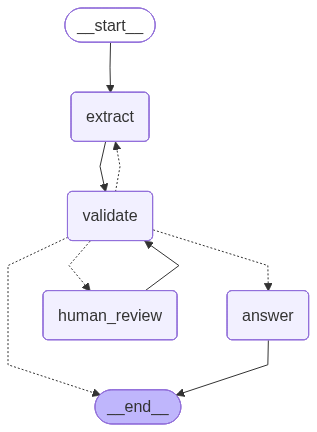

In [46]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [47]:
result = app.invoke({
    "question": "What does this document explain?",
    "documents": None,
    "chunks": None,
    "is_valid": False,
    "answer": None,
    "retry_count": 0,
    "human_reviewed": False
})

print("\nFINAL ANSWER:\n")
print(result["answer"])


 Middleware: Entering Extract Agent
Current State Keys: ['question', 'documents', 'chunks', 'is_valid', 'answer', 'retry_count', 'human_reviewed']

 Middleware: Entering Validate Agent
Current State Keys: ['question', 'documents', 'chunks', 'is_valid', 'answer', 'retry_count', 'human_reviewed']
Validation Result: True
Sending to Human Review

 Middleware: Entering Human Review Agent
Current State Keys: ['question', 'documents', 'chunks', 'is_valid', 'answer', 'retry_count', 'human_reviewed']
Extracted Context Preview:

• Implemented user authentication and CRUD operations to enhance website
functionality.
STARFLEET | Data Analyst
March 2024 – April 2024 | Intern
• Performed data analysis and derived actionable insights using Power BI for
Supply Chain Management for Cars.
• Designed interactive dashboards and detailed reports to improve data
visualization and insights.
PROJECTS
PERSONALIZED CAREER DEVELOPMENT | P

Approve this extraction?
Type 'y' to approve, anything else to reject.

